In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor, from_numpy, flatten, nn
import operator
from functools import partial

import pandas as pd
import numpy as np

import torch.nn.functional as F
from utils import get_data, get_data_mnist

### Get the KMNIST training data as before

In [2]:
X_train, X_test, y_train, y_test = get_data()

Quick check to make sure we haven't loaded tensors in nwrong order

In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([60000, 784]),
 torch.Size([10000, 784]),
 torch.Size([60000]),
 torch.Size([10000]))

In [4]:
n,m = X_train.shape
# num_classes:
c = int(y_train.max()+1)
nh = 50

### Training loop:
1. run batch through model to get predictions
2. calculate the loss with loss(pred, actual)
3. calculate grad of each param with backpropgation
4. update the params

For multiclass classification, the loss function we use is the cross entropy (in pytorch this is deinfed in `F.cross_entropy`

We use batches of data because in a normal setting the whole dataset is unlikely to fit into memory, and we would also not want to run images one by one through the network because that is rather inefficient (and also there are other tweaks, e.g. batchnorm, that expects more than 1 trainign sample to pass through at a time)

In [23]:
# if we use accuracy as the metric:
def accuracy(pred, actual):
    return (torch.argmax(pred, dim=1).int()== actual.int()).float().mean()


Redefine our simple model. This time, we are not adding the loss function to the model itself

In [194]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, c)]
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x


Instead, we define our loss function as the pytorch cross entropy loss:

In [195]:
loss_func = F.cross_entropy

##### 1. run one batch through the model:

In [196]:
bs = 64
model = Model(m, nh, c)
batch = X_train[:bs, :]
preds = model(batch)

xb = X_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([ 0.5825, -0.1432,  0.4810,  0.2529,  0.1810, -0.4233, -0.1339,  0.0740,
         -0.1272, -0.7218], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [197]:
# since the model isn't trained, we would expect the model to get around 1/10 correct by pure chance
accuracy(preds, y_train[:bs].int())

tensor(0.1406)

##### calculate the loss with cross entropy loss

In [198]:
# the loss function is what we're calculating the gradients against to optimise the params
loss_func(preds, y_train[:bs])

tensor(2.3778, grad_fn=<NllLossBackward>)

In [199]:
preds.size()

torch.Size([64, 10])

#### 3. Calculate the grad + update 
the whole training loop now since it's easier to see what's going on. Remeber that each gradient step, we are going in the opposite direction to the loss since we want to reduce it (hence the -ve dloss/dparam * learning rate)

In [200]:
lr = 0.5
epochs = 2
for epoch in range(epochs):
    for i in range((n + 1)//bs + 1):
        start_index = i * bs
        end_index = start_index + bs
        #forward pass
        x = X_train[start_index: end_index, :]
        y = y_train[start_index: end_index]
        loss = loss_func(model(x), y)
        #backward pass to get the grad
        loss.backward()
        # update the params-- set to no grad since we don't want to gradients to change while we're updating
        # if we forget this step we'll get a `RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.` error
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    # reset the grad to zero since we don't want to accumulate gradients
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

Not bad, considering that we only used a very simple network with 2 epochs' training

In [205]:
accuracy(model(X_test), y_test.int())

tensor(0.8190)

#### The pytorch way of doing things: 
In pytorch, the variables that we update as we train the network can be fetched by a call to `model.parameters()`. Also, the alternative to using a Relu layer class is to just use F.relu from torch.functional. Let's simplify the model

In [18]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [19]:
model = Model(m, nh, c)

We can see the layer in the model just by printing it

In [7]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [8]:
# and to print out the trainiable params
for name, param in model.named_parameters():
    print(name, param)

l1.weight Parameter containing:
tensor([[ 0.0174,  0.0241, -0.0010,  ..., -0.0231,  0.0328,  0.0309],
        [ 0.0038,  0.0221, -0.0222,  ..., -0.0221, -0.0011, -0.0122],
        [ 0.0140,  0.0150, -0.0122,  ...,  0.0326,  0.0024,  0.0165],
        ...,
        [ 0.0131,  0.0238, -0.0044,  ...,  0.0031, -0.0255,  0.0249],
        [ 0.0209,  0.0198, -0.0146,  ...,  0.0298, -0.0345, -0.0034],
        [ 0.0103, -0.0169, -0.0052,  ..., -0.0125,  0.0308,  0.0098]],
       requires_grad=True)
l1.bias Parameter containing:
tensor([-0.0153,  0.0025,  0.0105,  0.0173,  0.0316, -0.0248, -0.0113,  0.0222,
        -0.0318,  0.0057,  0.0198,  0.0165, -0.0321,  0.0308,  0.0154,  0.0301,
         0.0024, -0.0148,  0.0182, -0.0005,  0.0343,  0.0194,  0.0073, -0.0181,
        -0.0298, -0.0166,  0.0087,  0.0056,  0.0100, -0.0004,  0.0228,  0.0325,
         0.0120,  0.0163,  0.0282,  0.0356,  0.0205,  0.0130,  0.0196, -0.0246,
        -0.0204,  0.0021, -0.0115,  0.0134, -0.0073, -0.0014,  0.0134, -0.018

In [20]:
def train(epochs, lr, batch_size=64):
    for epoch in range(epochs):
        for i in range((n + 1)//batch_size + 1):
            start_index = i * batch_size
            end_index = start_index + batch_size
            #forward pass
            x = X_train[start_index: end_index, :]
            y = y_train[start_index: end_index]
            loss = F.cross_entropy(model(x), y)
            #backward pass to get the grad
            loss.backward()
            # update the params-- its quite a bit simiplier since pytorch takes care fo tracking all of them down
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad* lr
                model.zero_grad()

In [24]:
train(2, 0.5)
accuracy(model(X_test), y_test.int())

tensor(0.8042)

### A different way of defining layers-- nn.Modulelist

In [27]:
class SequentialModel(nn.ModuleList):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [28]:
model = SequentialModel([nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c)])
train(4, 0.2)
accuracy(model(X_test), y_test.int())

tensor(0.8339)

Or, we can just use nn.Sequential instead

In [29]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
train(6, 0.2)
accuracy(model(X_test), y_test.int())

tensor(0.8432)

#### Optimizers

Since we will be calling the update step for every minibatch training, we can package this up:
```python
with torch.no_grad():
    for p in model.parameters():
        p -= p.grad* lr
    model.zero_grad()
```                

In [47]:
class Optimizer():
    def __init__(self, params, lr = 0.5):
        self.params = list(params) #explicit cast to list in cast params is an iterator
        self.lr = lr 
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad* self.lr
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

def train(epochs, lr, batch_size=64):
    optimizer = Optimizer(model.parameters(), lr)
    for epoch in range(epochs):
        for i in range((n + 1)//batch_size + 1):
            start_index = i * batch_size
            end_index = start_index + batch_size
            #forward pass
            x = X_train[start_index: end_index, :]
            y = y_train[start_index: end_index]
            loss = F.cross_entropy(model(x), y)
            #backward pass to get the grad
            loss.backward()
            # update the params-- its quite a bit simiplier since pytorch takes care fo tracking all of them down
            optimizer.step()
            optimizer.zero_grad()

In [48]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
train(6, 0.2)
accuracy(model(X_test), y_test.int())

tensor(0.8410)

Or, we can just use pytorch's `optim` instead. 
From the docs:

>`torch.optim` is a package implementing various optimization algorithms.
Most commonly used methods are already supported, and the interface is general
enough, so that more sophisticated ones can be also easily integrated in the
future.

Usage, e.g. 

```python
optimizer = optim.SGD(model.parameters(), learning_rate)
optimizer.step()
optimizer.zero_grad()
```

In [49]:
from torch import optim

In [55]:
def generate_model(learning_rate):
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    return model, optimizer
    
def train(model, epochs, optimizer, batch_size=64):
    for epoch in range(epochs):
        for i in range((n + 1)//batch_size + 1):
            start_index = i * batch_size
            end_index = start_index + batch_size
            #forward pass
            x = X_train[start_index: end_index, :]
            y = y_train[start_index: end_index]
            loss = F.cross_entropy(model(x), y)
            #backward pass to get the grad
            loss.backward()
            # update the params-- its quite a bit simiplier since pytorch takes care fo tracking all of them down
            optimizer.step()
            optimizer.zero_grad()

In [56]:
model, optimizer = generate_model(0.2)
train(model, 6, optimizer)
accuracy(model(X_test), y_test)

tensor(0.8389)

### Dataset/ Dataloader

It is easier to make a mistake if we have to declare x, y batches separately every time. Also, if we have a test set, we would want to apply the same normalisation as we did to our train set, so we can combine them

In [57]:
class Dataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        assert len(x) == len(y), "size mismatch between x and y"
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return len(self.x)

In [72]:
train_ds = Dataset(X_train, y_train)
valid_ds = Dataset(X_test, y_test)
def train(model, epochs, optimizer, batch_size=64):
    for epoch in range(epochs):
        for i in range((n + 1)//batch_size + 1):

            start_index = i * batch_size
            end_index = start_index + batch_size
            #forward pass
            x, y = train_ds[start_index: end_index]
            loss = F.cross_entropy(model(x), y)
            #backward pass to get the grad
            loss.backward()
            # update the params-- its quite a bit simiplier since pytorch takes care fo tracking all of them down
            optimizer.step()
            optimizer.zero_grad()

model, optimizer = generate_model(0.2)
train(model, 6, optimizer)
accuracy(model(X_test), y_test)

tensor(0.8401)

Actually, why don't we get rid of the `for i in range((n + 1)//batch_size + 1):...` and use an generator to yiedl batches instead?

In [153]:
class Dataloader():
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        
    def __iter__(self):
        for i in range((len(self.dataset) + 1)//self.batch_size + 1):
            start_index = i * self.batch_size
            end_index = start_index + self.batch_size
            yield self.dataset[start_index: end_index]
            
def train(model, epochs, optimizer, dataloader):
    for epoch in range(epochs):
        for x, y in dataloader:     
            loss = F.cross_entropy(model(x), y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


In [154]:
train_ds = Dataset(X_train, y_train)
valid_ds = Dataset(X_test, y_test)
train_dl = Dataloader(train_ds, 64)
valid_dl = Dataloader(valid_ds, 64)

In [155]:
model, optimizer = generate_model(0.2)
train(model, 6, optimizer, train_dl)
accuracy(model(X_test), y_test)

tensor(0.8227)

### Random sampling

We want to shuffle the training set every epoch otherwise the model might pick up unwanted patterns. The validation set should remain the same so we can test model perf properly.

We can do shuffling with 
```python 
"""Returns a random permutation of integers from 0 to n - 1"""
torch.randperm(n)
```


In [92]:
class Sampler:
    def __init__(self, batch_size, dataset, shuffle=False):
        self.batch_size = batch_size
        self.dataset = dataset
        self.shuffle = shuffle
        self.dataset_size = len(dataset)
        
    def __iter__(self):
        random_idx = torch.randperm(self.dataset_size) if self.shuffle else torch.arange(self.dataset_size)
        for i in range(0, self.dataset_size, self.batch_size):
            yield random_idx[i: i + self.batch_size]

In [181]:

class Dataloader:
    def __init__(self, dataset, batch_size, sampler):
        self.dataset = dataset
        self.batch_size = batch_size
        self.sampler = sampler
        
    def __iter__(self):
        sample_indexes = next(iter(self.sampler))
        yield self.dataset[sample_indexes]
        
    def __iter__(self):
        for sample_indexes in self.sampler:
            yield self.dataset[sample_indexes]

In [182]:
train_sampler =Sampler(64, train_ds, shuffle=True)
valid_sampler =Sampler(64, valid_ds, shuffle=False)

In [184]:
train_dl = Dataloader(train_ds, 64, train_sampler)
valid_dl = Dataloader(valid_ds, 64, valid_sampler)


In [163]:
xbatch, ybatch=next(iter(valid_dl))

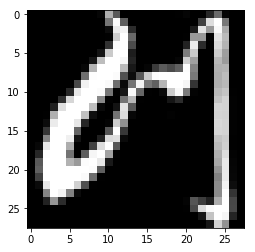

In [164]:
plt.imshow(xbatch[26].view(28,28), cmap="gray")

In [165]:
ybatch[26]

tensor(3)

In [123]:
x, y  = next(iter(valid_dl))

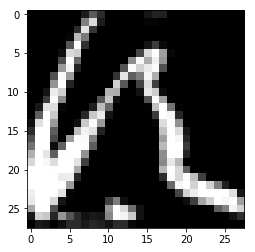

In [143]:
plt.imshow(x[26].view(28,28), cmap="gray")

In [128]:
y[20]

tensor(7)

In [185]:
def train(model, epochs, optimizer, dataloader):
    for epoch in range(epochs):
        for x, y in dataloader:     
            loss = F.cross_entropy(model(x), y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
model, optimizer = generate_model(0.2)
train(model, 6, optimizer, train_dl)
accuracy(model(X_test), y_test)

tensor(0.8539)

#### Pytorch dataloader

In fact, pytorch already has an inbuilt dataloader / sampler. It is an iterator which can also do multiprocessing 

In [186]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [187]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=3)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False, num_workers=3)

Prediction more or less as expected

In [188]:
model, optimizer = generate_model(0.2)
train(model, 6, optimizer, train_dl)
accuracy(model(X_test), y_test)

tensor(0.8468)

#### Validation set

Using a validation set is important for model training. In pytorch, you have to specify `model.train()` and `model.eval()` for the 2 phases because it needs to handle ops like dropout (you only do dropout on the training, not validation/test) and batchnorm, which in training depends on minb

In [193]:
def train(model, epochs, optimizer, loss_function, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for x,y in train_dl:
            loss = loss_function(model(x), y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 
            
        model.eval()
        with torch.no_grad():
            total_loss, total_accuracy = 0.,0.
            for x, y in valid_dl:
                pred = model(x)
                total_loss += loss_function(pred, y)
                total_accuracy += accuracy(pred, y)
        print(f"epoch:{epoch} \n accuracy:{total_accuracy/len(valid_dl)} \n loss:{total_loss/len(valid_dl)}")



In [195]:
model, optimizer = generate_model(0.2)
train(model, 6, optimizer, F.cross_entropy, train_dl, valid_dl)

epoch:0 
 accuracy:0.8273288011550903 
 loss:0.5736130475997925
epoch:1 
 accuracy:0.8340963125228882 
 loss:0.5830450057983398
epoch:2 
 accuracy:0.8418591022491455 
 loss:0.5828751921653748
epoch:3 
 accuracy:0.8529060482978821 
 loss:0.5513807535171509
epoch:4 
 accuracy:0.8612658977508545 
 loss:0.5524911284446716
epoch:5 
 accuracy:0.8446456789970398 
 loss:0.6490485072135925
